In [7]:
import py3dcore as py3dcore
import datetime as datetime
import numpy as np
import os as os
import pickle as pickle
import matplotlib.pyplot as plt
import spiceypy as spiceypy

#import heliopy.spice as spice
#import heliopy.data.spice as spicedata

import heliosat as heliosat
from heliosat.util import sanitize_dt

from py3dcore.methods.method import BaseMethod

import logging

logger = logging.getLogger(__name__)


In [8]:
def loadpickle(path = None, number = -1):

    """ Loads the filepath of a pickle file. """

    # Get the list of all files in path
    dir_list = sorted(os.listdir(path))

    resfile = []
    respath = []
    # we only want the pickle-files
    for file in dir_list:
        if file.endswith(".pickle"):
            resfile.append(file) 
            respath.append(os.path.join(path,file))
            
    filepath = path + resfile[number]

    return filepath


def generate_ensemble(path: str, dt: datetime.datetime, reference_frame: str="HCI", reference_frame_to: str="HCI", perc: float=0.95, max_index=None) -> np.ndarray:
    
    """
    Generates an ensemble from a Fitter object.
    
    Arguments:
        path                where to load from
        dt                  time axis used for fitting
        reference_frame     reference frame used for fitter object
        reference_frame_to  reference frame for output data
        perc                percentage of quantile to be used
        max_index           how much of ensemble is kept
        custom_data         path to custom data
    Returns:
        ensemble_data 
    """
    
    observers = BaseMethod(path).observers
    ensemble_data = []
    

    for (observer, _, _, _, _) in observers:
        ftobj = BaseMethod(path) # load Fitter from path
        
        #if custom_data == False:
        observer_obj = getattr(heliosat, observer)() # get observer obj
        # logger.info("Using HelioSat to retrieve observer data")
        #else:
        #    observer_obj = custom_observer(custom_data)
        #    logger.info("Using custom datafile: %s", custom_data)
            
            
            
        # simulate flux ropes using iparams from loaded fitter
        ensemble = np.squeeze(np.array(ftobj.model_obj.simulator(dt, observer_obj.trajectory(dt, reference_frame=reference_frame))[0]))
        
        # how much to keep of the generated ensemble
        if max_index is None:
            max_index =  ensemble.shape[1]

        ensemble = ensemble[:, :max_index, :]

        # transform frame
        if reference_frame != reference_frame_to:
            for k in range(0, ensemble.shape[1]):
                ensemble[:, k, :] = transform_reference_frame(dt, ensemble[:, k, :], reference_frame, reference_frame_to)

        ensemble[np.where(ensemble == 0)] = np.nan

        # generate quantiles
        b_m = np.nanmean(ensemble, axis=1)

        b_s2p = np.nanquantile(ensemble, 0.5 + perc / 2, axis=1)
        b_s2n = np.nanquantile(ensemble, 0.5 - perc / 2, axis=1)

        b_t = np.sqrt(np.sum(ensemble**2, axis=2))
        b_tm = np.nanmean(b_t, axis=1)

        b_ts2p = np.nanquantile(b_t, 0.5 + perc / 2, axis=1)
        b_ts2n = np.nanquantile(b_t, 0.5 - perc / 2, axis=1)

        ensemble_data.append([None, None, (b_s2p, b_s2n), (b_ts2p, b_ts2n)])
        
        return ensemble_data
    
    
def get_params(filepath, give_mineps=False):
    
    """ Gets params from file. """
    
    # read from pickle file
    file = open(filepath, "rb")
    data = pickle.load(file)
    file.close()
    
    model_objt = data["model_obj"]
    maxiter = model_objt.ensemble_size-1

    # get index ip for run with minimum eps    
    epses_t = data["epses"]
    ip = np.argmin(epses_t[0:maxiter])    
    
    # get parameters (stored in iparams_arr) for the run with minimum eps
    
    iparams_arrt = model_objt.iparams_arr
    
    meanparams = np.mean(model_objt.iparams_arr, axis=0)
    
    resparams = iparams_arrt[ip]
    
    names = ['lon: ', 'lat: ', 'inc: ', 'diameter 1 AU: ', 'aspect ratio: ', 'launch radius: ', 'launch speed: ', 't factor: ', 'expansion rate: ', 'magnetic field decay rate: ', 'magnetic field 1 AU: ', 'drag coefficient: ', 'background sw speed: ']
    if give_mineps == True:
        logger.info("Retrieved the following parameters for the run with minimum epsilon:")
    
        for count, name in enumerate(names):
            logger.info(" --{} {:.2f}".format(name, resparams[count+1]))
            print(" --{} {:.2f}".format(name, resparams[count+1]))

    return resparams, iparams_arrt, ip, meanparams    

In [17]:
t_s = datetime.datetime(2022, 9, 7, 8, tzinfo=datetime.timezone.utc) 
t_e = datetime.datetime(2022, 9, 8, 3, tzinfo=datetime.timezone.utc)

t_fit = [
    datetime.datetime(2022, 9, 7, 9, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 7, 15, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 7, 20, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 8, 2, tzinfo=datetime.timezone.utc)
]

In [18]:
path = 'solo06092022_512_soloRTN/'

filepath = loadpickle(path, number=-1)

In [19]:
filepath

'solo06092022_512_soloRTN/07.pickle'

/var/folders/8p/f6f43d0952ldf2v3pj7yp_y40000gn/T/ipykernel_85451/3238724467.py:71: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/var/folders/8p/f6f43d0952ldf2v3pj7yp_y40000gn/T/ipykernel_85451/3238724467.py:77: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


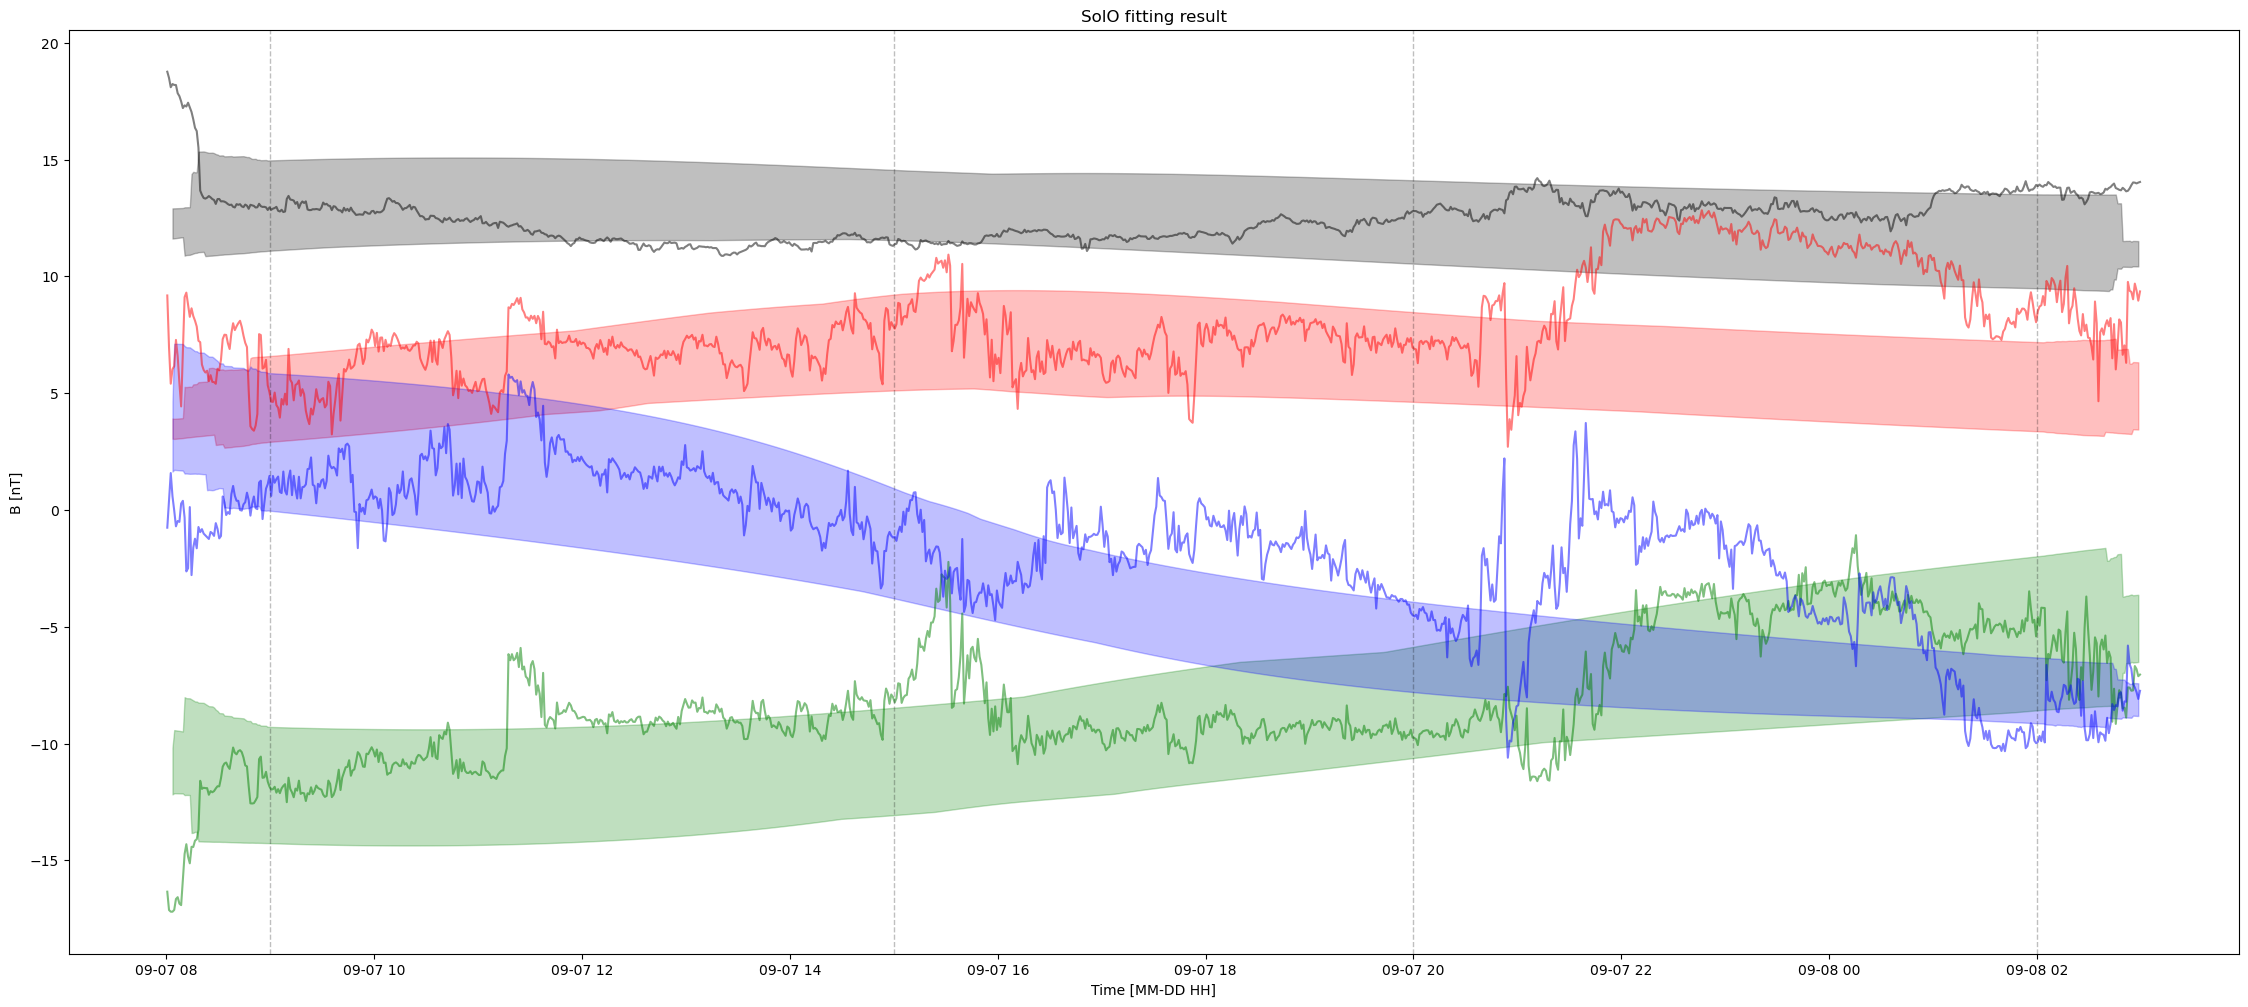

In [25]:
t, b = heliosat.SOLO().get([t_s, t_e], "mag", reference_frame="SOLO_SUN_RTN", as_endpoints=True, return_datetimes=True, smoothing=None)#, smoothing_scale=300)

ed = generate_ensemble(filepath, t, reference_frame="SOLO_SUN_RTN", reference_frame_to="SOLO_SUN_RTN", max_index=32)

plt.figure(figsize=(28, 12))
plt.title("SolO fitting result")
plt.plot(t, np.sqrt(np.sum(b**2, axis=1)), "k", alpha=0.5)
plt.plot(t, b[:, 0], "r", alpha=0.5)
plt.plot(t, b[:, 1], "g", alpha=0.5)
plt.plot(t, b[:, 2], "b", alpha=0.5)
plt.fill_between(t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_fit:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.show()

In [23]:
res, allres, ind, meanparams = get_params(filepath, give_mineps=True)

 --lon:  -23.81
 --lat:  7.25
 --inc:  22.19
 --diameter 1 AU:  0.28
 --aspect ratio:  3.33
 --launch radius:  14.97
 --launch speed:  982.64
 --t factor:  163.38
 --expansion rate:  1.14
 --magnetic field decay rate:  1.64
 --magnetic field 1 AU:  6.56
 --drag coefficient:  0.25
 --background sw speed:  371.98


In [ ]:
t_s_wind = datetime.datetime(2022, 2, 1, tzinfo=datetime.timezone.utc)
t_e_wind = datetime.datetime(2022, 2, 5, tzinfo=datetime.timezone.utc)

t_wind = [
    datetime.datetime(2022, 2, 3, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 3,2, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 3,4, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 3,6, tzinfo=datetime.timezone.utc),
]

wind_t, wind_b = heliosat.WIND().get([t_s_wind, t_e_wind], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

ed = py3dcore.generate_ensemble("out_wind_heeq/05.pickle", wind_t, reference_frame="HEEQ", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("Wind fitting result")
plt.plot(wind_t, np.sqrt(np.sum(wind_b**2, axis=1)), "k", alpha=0.5)
plt.plot(wind_t, wind_b[:, 0], "r", alpha=0.5)
plt.plot(wind_t, wind_b[:, 1], "g", alpha=0.5)
plt.plot(wind_t, wind_b[:, 2], "b", alpha=0.5)
plt.fill_between(wind_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(wind_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(wind_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(wind_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_wind:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.show()

In [ ]:
t_s_solo = datetime.datetime(2022, 1, 31, tzinfo=datetime.timezone.utc)
t_e_solo = datetime.datetime(2022, 2, 3, tzinfo=datetime.timezone.utc)

t_solo = [
    datetime.datetime(2022, 2, 2,4, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,6, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,8, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,10, tzinfo=datetime.timezone.utc)
]

solo_t, solo_b = heliosat.SOLO().get([t_s_solo, t_e_solo], "mag", reference_frame="SOLO_SUN_RTN", as_endpoints=True, return_datetimes=True, 
                                     smoothing="gaussian")#, skip_download=True)

ed = py3dcore.generate_ensemble("out_solo_heeq/08.pickle", solo_t, reference_frame="HEEQ", reference_frame_to="SOLO_SUN_RTN", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("SolO fitting result")
plt.plot(solo_t, np.sqrt(np.sum(solo_b**2, axis=1)), "k", alpha=0.5)
plt.plot(solo_t, solo_b[:, 0], "r", alpha=0.5)
plt.plot(solo_t, solo_b[:, 1], "g", alpha=0.5)
plt.plot(solo_t, solo_b[:, 2], "b", alpha=0.5)
plt.fill_between(solo_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(solo_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(solo_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(solo_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_solo:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.show()

In [ ]:
t_s_solo = datetime.datetime(2022, 1, 31, tzinfo=datetime.timezone.utc)
t_e_solo = datetime.datetime(2022, 2, 3, tzinfo=datetime.timezone.utc)

t_solo = [
    datetime.datetime(2022, 2, 2,4, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,6, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,8, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,10, tzinfo=datetime.timezone.utc)
]

t_s_sta = datetime.datetime(2022, 2, 2, 10, tzinfo=datetime.timezone.utc)
t_e_sta = datetime.datetime(2022, 2, 3, 6, tzinfo=datetime.timezone.utc)

t_sta = [
    datetime.datetime(2022, 2, 2,16, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,18, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,20, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 2, 2,21, tzinfo=datetime.timezone.utc)
]


ed = py3dcore.generate_ensemble("out_sta+solo_heeq/07.pickle", solo_t, reference_frame="HEEQ", reference_frame_to="SOLO_SUN_RTN", max_index=128)
ed2 = py3dcore.generate_ensemble("out_sta+solo_heeq/07.pickle", sta_t, reference_frame="HEEQ", reference_frame_to="STAHGRTN", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("SolO fitting result")
plt.plot(solo_t, np.sqrt(np.sum(solo_b**2, axis=1)), "k", alpha=0.5)
plt.plot(solo_t, solo_b[:, 0], "r", alpha=0.5)
plt.plot(solo_t, solo_b[:, 1], "g", alpha=0.5)
plt.plot(solo_t, solo_b[:, 2], "b", alpha=0.5)
plt.fill_between(solo_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(solo_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(solo_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(solo_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_solo:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.show()

plt.figure(figsize=(28, 12))
plt.title("STA fitting result")
plt.plot(sta_t, np.sqrt(np.sum(sta_b**2, axis=1)), "k", alpha=0.5)
plt.plot(sta_t, sta_b[:, 0], "r", alpha=0.5)
plt.plot(sta_t, sta_b[:, 1], "g", alpha=0.5)
plt.plot(sta_t, sta_b[:, 2], "b", alpha=0.5)
plt.fill_between(sta_t, ed2[1][3][0], ed2[1][3][1], alpha=0.25, color="k")
plt.fill_between(sta_t, ed2[1][2][0][:, 0], ed2[1][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(sta_t, ed2[1][2][0][:, 1], ed2[1][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(sta_t, ed2[1][2][0][:, 2], ed2[1][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_sta:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.show()

In [5]:
fit_wind = py3dcore.ABC_SMC("output/psp02062022_512_final_1/10.pickle")
fit_wind_mean = np.mean(fit_wind.model_obj.iparams_arr, axis=0)
fit_wind_std = np.std(fit_wind.model_obj.iparams_arr, axis=0)

keys = list(fit_wind.model_obj.iparams.keys())

print("Results (PSP):\n")
for i in range(1, len(keys)):
    print("\t{}: \t\t{:.02f} +/- {:.02f}".format(keys[i], fit_wind_mean[i], fit_wind_std[i]))



Results (PSP):

	cme_longitude: 		-36.07 +/- 8.01
	cme_latitude: 		9.84 +/- 5.81
	cme_inclination: 		338.78 +/- 5.75
	cme_diameter_1au: 		0.32 +/- 0.02
	cme_aspect_ratio: 		1.35 +/- 0.26
	cme_launch_radius: 		10.85 +/- 1.44
	cme_launch_velocity: 		408.44 +/- 125.18
	t_factor: 		-260.24 +/- 27.10
	cme_expansion_rate: 		1.14 +/- 0.00
	magnetic_decay_rate: 		1.64 +/- 0.00
	magnetic_field_strength_1au: 		8.73 +/- 1.24
	background_drag: 		1.10 +/- 0.48
	background_velocity: 		367.77 +/- 158.05


In [ ]:
fit_wind = py3dcore.ABC_SMC("out_sta_heeq/07.pickle")
fit_wind_mean = np.mean(fit_wind.model_obj.iparams_arr, axis=0)
fit_wind_std = np.std(fit_wind.model_obj.iparams_arr, axis=0)

keys = list(fit_wind.model_obj.iparams.keys())

print("Results (STA):\n")
for i in range(1, len(keys)):
    print("\t{}: \t\t{:.02f} +/- {:.02f}".format(keys[i], fit_wind_mean[i], fit_wind_std[i]))




In [ ]:
fit_wind = py3dcore.ABC_SMC("out_sta+solo_heeq/07.pickle")
fit_wind_mean = np.mean(fit_wind.model_obj.iparams_arr, axis=0)
fit_wind_std = np.std(fit_wind.model_obj.iparams_arr, axis=0)

keys = list(fit_wind.model_obj.iparams.keys())

print("Results (STA+SOLO):\n")
for i in range(1, len(keys)):
    print("\t{}: \t\t{:.02f} +/- {:.02f}".format(keys[i], fit_wind_mean[i], fit_wind_std[i]))





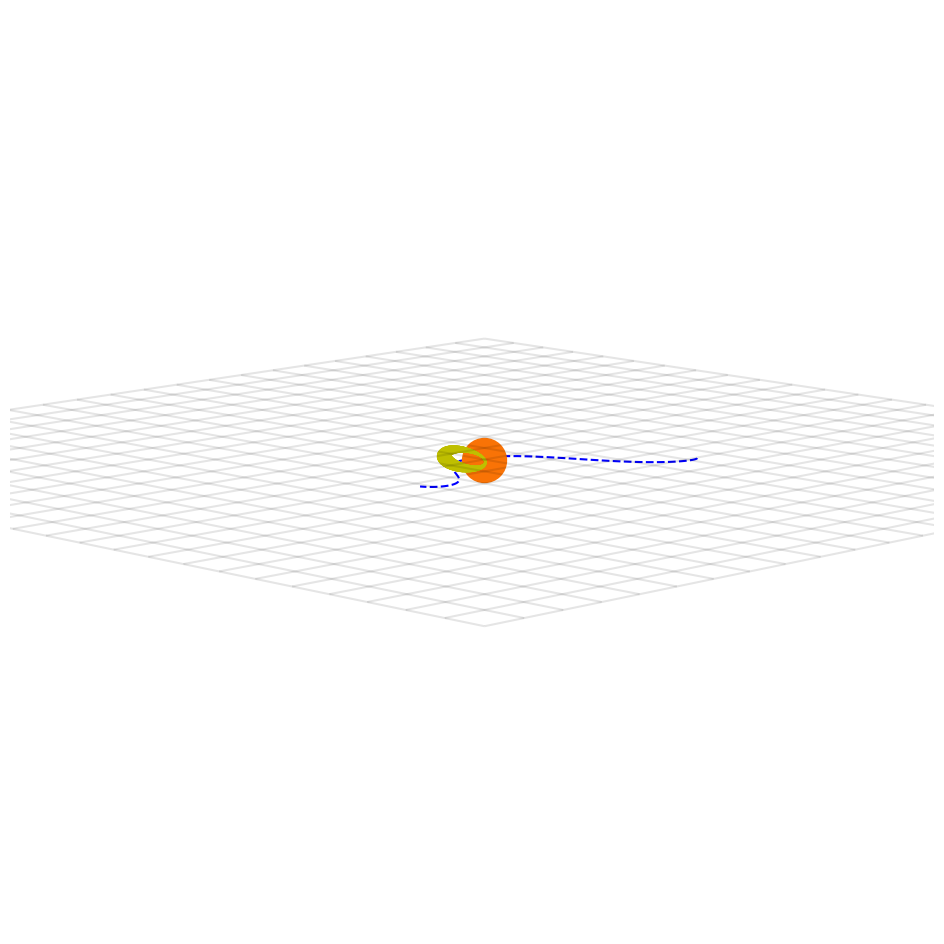

In [29]:
fit_wind.model_obj.propagator(datetime.datetime(2022, 6, 3, tzinfo=datetime.timezone.utc))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
#wf=fit_wind.model_obj.visualize_shape(iparam_index=2)
wf=fit_wind.model_obj.visualize_shape(iparam_index=4)

ax.plot_wireframe(*wf.T, color="y")

t_snap = datetime.datetime(2022, 6, 2, tzinfo=datetime.timezone.utc)


draw_obj = ["PSP"]
draw_colors = ["b"]

ax.scatter(0, 0, 0, s=1000, color="xkcd:orange")

for i in range(len(draw_obj)):
    hobj = getattr(heliosat, draw_obj[i])()
    pos = hobj.trajectory(t_snap, reference_frame="HEEQ")
    path = hobj.trajectory([t_snap + datetime.timedelta(days=i) for i in range(-50, 50)], reference_frame="HEEQ")

    ax.scatter(*pos, color=draw_colors[i], s=150)
    ax.plot(*path.T, color=draw_colors[i], ls="--")
    
    # draw plane
    xx, yy = np.meshgrid(np.linspace(-2, 2, 25), np.linspace(-2, 2, 25))
    zz = np.zeros_like(xx)
    ax.plot_wireframe(xx, yy, zz, alpha=0.1, color="k")
    
    ax.set_axis_off()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

ax.set_axis_off()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=10, azim=45)

In [ ]:
fit_wind.model_obj.propagator(datetime.datetime(2022, 2, 3, tzinfo=datetime.timezone.utc))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
wf=fit_wind.model_obj.visualize_shape(iparam_index=2)

ax.plot_wireframe(*wf.T)

t_snap = datetime.datetime(2022, 2, 3, tzinfo=datetime.timezone.utc)


draw_obj = ["Earth", "SOLO", "STA"]
draw_colors = ["g", "b", "m"]

ax.scatter(0, 0, 0, s=1000, color="xkcd:orange")

for i in range(len(draw_obj)):
    hobj = getattr(heliosat, draw_obj[i])
    pos = hobj().trajectory(t_snap, reference_frame="HEEQ")
    path = hobj().trajectory([t_snap + datetime.timedelta(days=i) for i in range(-50, 50)], reference_frame="HEEQ")

    ax.scatter(*pos, color=draw_colors[i], s=150)
    ax.plot(*path.T, color=draw_colors[i], ls="--")
    
    # draw plane
    xx, yy = np.meshgrid(np.linspace(-2, 2, 25), np.linspace(-2, 2, 25))
    zz = np.zeros_like(xx)
    ax.plot_wireframe(xx, yy, zz, alpha=0.1, color="k")
    
    ax.set_axis_off()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

ax.set_axis_off()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=90, azim=-90)

In [ ]:
fit_wind.model_obj.propagator(datetime.datetime(2022, 2, 3, tzinfo=datetime.timezone.utc))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
wf=fit_wind.model_obj.visualize_shape(iparam_index=2)

ax.plot_wireframe(*wf.T)

t_snap = datetime.datetime(2022, 2, 3, tzinfo=datetime.timezone.utc)


draw_obj = ["Earth", "SOLO", "STA"]
draw_colors = ["g", "b", "m"]

ax.scatter(0, 0, 0, s=1000, color="xkcd:orange")

for i in range(len(draw_obj)):
    hobj = getattr(heliosat, draw_obj[i])
    pos = hobj().trajectory(t_snap, reference_frame="HEEQ")
    path = hobj().trajectory([t_snap + datetime.timedelta(days=i) for i in range(-50, 50)], reference_frame="HEEQ")

    ax.scatter(*pos, color=draw_colors[i], s=150)
    ax.plot(*path.T, color=draw_colors[i], ls="--")
    
    # draw plane
    xx, yy = np.meshgrid(np.linspace(-2, 2, 25), np.linspace(-2, 2, 25))
    zz = np.zeros_like(xx)
    ax.plot_wireframe(xx, yy, zz, alpha=0.1, color="k")
    
    ax.set_axis_off()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

ax.set_axis_off()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=0, azim=-90)